Jupyter notebook to scrape tweets with #MaRS from 10/02/2020 to 11/02/2020, and build
a model to detect tweet topics

1. Scrape tweets 
2. Data pre-processing - lemmetize, remove stop words,etc.
3. Generating word cloud
4. Train LDA model
5. Visualizing topics

In [1]:
hashtag = "MARS"

In [2]:
from twitterscraper import query_tweets
import pandas as pd
import re, pickle, os

import datetime 
import nltk
from nltk.util import ngrams

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords, wordnet 

from collections import Counter 
from nltk.stem import WordNetLemmatizer

import gensim
from gensim import corpora, models
from gensim.corpora import MmCorpus
from gensim.models.coherencemodel import CoherenceModel

import pyLDAvis.gensim

from time import time

from IPython.core.display import HTML
from pprint import pprint

INFO: {'User-Agent': 'Mozilla/5.0 (Windows NT 5.2; RW; rv:7.0a1) Gecko/20091211 SeaMonkey/9.23a1pre'}
C:\ProgramData\Anaconda3\envs\py36\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\tryam\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tryam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tryam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Define Constants

In [4]:
# Search tweets that have keyword
TWEET_QUERY = 'MaRS'
BEGINDATE = datetime.date(2020, 2, 10)
ENDDATE = datetime.date(2020, 2, 11)


In [5]:
FIGURE_PATH = r'./figures' + hashtag +'/'
DATA_PATH = r'./data' + hashtag +'/'
MODEL_PATH = r'./models' + hashtag +'/'


WORDCLOUD_FILE = FIGURE_PATH  +  'wordcloud.png'
WORD_COUNT_FILE = FIGURE_PATH + 'commond_words_freq.png'
TOPIC_VIS_FILE = FIGURE_PATH + 'lda.html'


ORIG_TWEET_FILE = DATA_PATH + 'all_tweets'
CLEANED_TWEET_FILE = DATA_PATH + 'tweets_cleaned_df'
CORPUS_FILE = MODEL_PATH + 'clean_tweets_corpus.mm'


DICT_FILE = MODEL_PATH + 'clean_tweets.dict'
LDA_MODEL_FILE = MODEL_PATH + 'tweets_lda.model'
LDA_TOPICS_FILE = MODEL_PATH + 'tweets_lda_topics.txt'


LANG = 'en'

In [6]:
if not (os.path.exists(FIGURE_PATH)):
  os.mkdir(FIGURE_PATH)

if not (os.path.exists(DATA_PATH)):
  os.mkdir(DATA_PATH)

if not (os.path.exists(MODEL_PATH)):
  os.mkdir(MODEL_PATH)

In [7]:
# ngrams or multi-word expressions
NUM_GRAMS = 2

# Number of topics
NUM_TOPICS = 10

# Number of training passes
NUM_PASSES = 20 

# Document-Topic Density. The lower alpha is, the more likely that 
# a document may contain mixture of just a few of the topics. 
# Default is 1.0/NUM_TOPICS
ALPHA = 0.01

# Word-Topic Density. The lower eta is, the more likely that 
# a topic may contain a mixture of just a few of the words
# Default is 1.0/NUM_TOPICS
ETA = 'auto'


In [8]:
# Function to for Part Part-of_speech (POS) 
#tag to first character lemmatize() accepts

def get_wordnet_pos(word):
  
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


#Funtion to pre-process test and return a list of cleaned words
def text_cleanup(text, additional_stop_words_2):  

    # Convert to lowercase
    text_clean = text.lower()

    # Remove non-alphabet
    text_clean = re.sub(r'[^a-zA-Z]|(\w+:\/\/\S+)',' ', text_clean).split()   

    # Remove short words (length < 3)
    text_clean = [w for w in text_clean if len(w)>2]

    # Lemmatize text with the appropriate POS tag
    lemmatizer = WordNetLemmatizer()
    text_clean = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text_clean]

    # Filter out stop words in English 
    stops = set(stopwords.words('english')).union(additional_stop_words_2)
    text_clean = [w for w in text_clean if w not in stops]
    
    return text_clean

In [9]:
#Function to Create word cloud

def wordcloud(word_count_df):

    # Convert DataFrame to Map so that word cloud can be generated from freq
    word_count_dict = {}
    for w, f in word_count_df.values:
        word_count_dict[w] = f

    # Generate word cloud 
    wordcloud = WordCloud(max_words=300, width=1400, height=900, 
                          random_state=12, contour_width=3, 
                          contour_color='firebrick')
    wordcloud.generate_from_frequencies(word_count_dict)
    plt.figure(figsize=(10,10), facecolor='k')
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

    # Save the word cloud image
    wordcloud.to_file(WORDCLOUD_FILE) 
    print ('Word cloud saved\n')
    
    return wordcloud
 
def read_data_from_pickle(infile):
    with open (infile, 'rb') as fp:
        return pickle.load(fp)
 
def save_data_to_pickle(outfile, all_tweets):
    with open(outfile, 'wb') as fp:
        pickle.dump(all_tweets, fp)
   
def save_print_to_file(outfile, msg):
    with open(outfile, 'w') as fp:
        print(msg, file=fp)  

In [10]:
#Scrape web for tweets and save to file

def get_all_tweets():

    if os.path.isfile(ORIG_TWEET_FILE):        
        tweets_df = read_data_from_pickle(ORIG_TWEET_FILE)  
        print('Loaded tweet extracts from file\n')

    else:
        print('Start scraping tweets from twitter.com...\n')
        
        list_of_tweets = query_tweets(TWEET_QUERY, 
                                      begindate=BEGINDATE, 
                                      enddate=ENDDATE, 
                                      lang=LANG)
        
        # Convert list of tweets to DataFrame
        tweets_df = pd.DataFrame([vars(x) for x in list_of_tweets])

        # Save tweet extracts to file
        save_data_to_pickle(ORIG_TWEET_FILE, tweets_df)
        print ('Tweet extracts saved to file\n')        
    
    return tweets_df

In [11]:
#Function to pre-process tweets

def preprocess_tweets(all_tweets_df, additional_stop_words_2):

    if True:
     if os.path.isfile(CLEANED_TWEET_FILE):

        # Read cleaned tweets from saved file
        cleaned_tweets_df = read_data_from_pickle(CLEANED_TWEET_FILE)
        print('Loaded cleaned tweets from file\n')
        os.remove(CLEANED_TWEET_FILE)

     else:

        print('Start preprocessing tweets ...\n')

        # dataframe to add parsed tweets 
        cleaned_tweets_df = all_tweets_df.copy(deep=True)

        # parsing tweets 
        cleaned_tweets_df['token'] = [text_cleanup(x, additional_stop_words_2)
         for x in all_tweets_df['text']]   

        # Save cleaned tweets to file
        save_data_to_pickle(CLEANED_TWEET_FILE, cleaned_tweets_df)
        print ('Cleaned tweets saved\n')
    
    return cleaned_tweets_df 

In [12]:
#Function to get word counts

def get_word_count(tweets_text, num_gram):

    n_grams = list(ngrams(tweets_text, num_gram))
    common_words = Counter(n_grams).most_common()
    word_count = pd.DataFrame(data = common_words, 
                              columns=['word','frequency']) 
    
    # Convert list to string
    word_count['word'] = word_count['word'].apply(' '.join)

    # Plot word count graph
    word_count.head(20).sort_values('frequency').plot.barh(
            x='word', y='frequency', title='Word Frequency',figsize=(19,10))
    plt.savefig(WORD_COUNT_FILE)
    print ('Word count saved\n')
    
    return word_count

In [13]:
#Function to build ngrams

def word_grams(words, min=1, max=2):
    word_list = []
    for n in range(min, max):
        for ngram in ngrams(words, n):
            word_list.append(' '.join(str(i) for i in ngram))
    return word_list

In [14]:
st = time()
all_tweets_df = get_all_tweets()
et = time()

print ('Time for web scrapping = {:3.2f} minutes'.format((et-st)/60))
#all_tweets_df.head(2)

additional_stop_words=['administrator', 'nasa', 'mar', 'rt', 'twitter',
                       'pic', 'com', 'via']
cleaned_tweets_df = preprocess_tweets(all_tweets_df, additional_stop_words) 


tweets_text = [word for one_tweet in cleaned_tweets_df['token']
               for word in one_tweet]

INFO: queries: ['MaRS since:2020-02-10 until:2020-02-11']


Start scraping tweets from twitter.com...



INFO: Got 9419 tweets (9419 new).


Tweet extracts saved to file

Time for web scrapping = 9.59 minutes
Start preprocessing tweets ...

Cleaned tweets saved



Word count saved



,word,frequency
0,moon initiative,503
1,statement moon,498
2,initiative budget,498
3,budget statement,327
4,quality time,71


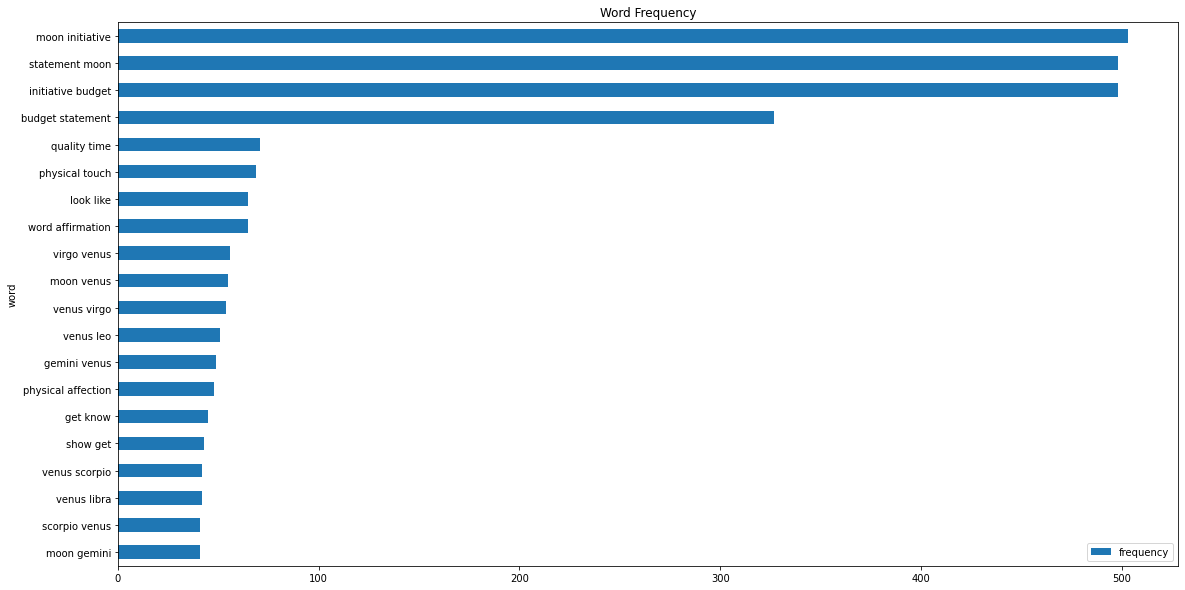

In [15]:
#Evaluate the common ngrams words count
word_count_df = get_word_count(tweets_text, num_gram=NUM_GRAMS)
word_count_df.head()

Word cloud saved



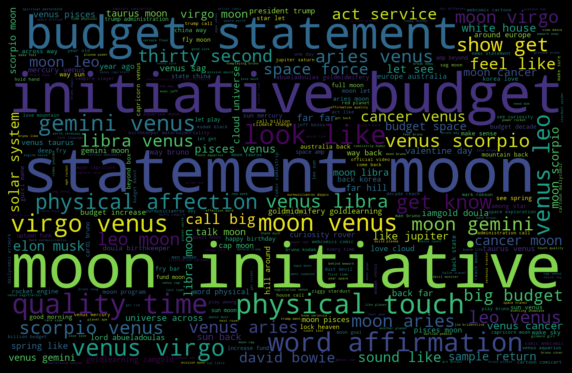

In [16]:
# Generate word cloud
tweets_wordcloud = wordcloud(word_count_df) 

In [17]:
import warnings

warnings.filterwarnings('ignore')

In [18]:
cleaned_tweets_df['ngram_token'] = [word_grams(x, NUM_GRAMS, NUM_GRAMS+1) for 
                  x in cleaned_tweets_df['token']]

In [19]:
token_tweets = cleaned_tweets_df['ngram_token']

tweets_dict = corpora.Dictionary(token_tweets)

# Remove words that occur less than 10 documents, 
# or more than 40% of the doc

tweets_dict.filter_extremes(no_below=10, no_above=0.4)

# Transform doc to a vectorized form by computing frequency of each word
bow_corpus = [tweets_dict.doc2bow(doc) for doc in token_tweets]

# Save corpus and dictionary to file
MmCorpus.serialize(CORPUS_FILE, bow_corpus)

tweets_dict.save(DICT_FILE)

# Create tf-idf model and then apply transformation to the entire corpus
tfidf = models.TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

In [20]:
#find the optimal number of topics for LDA
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):

         # Train LDA model
        lda_model = models.ldamodel.LdaModel(corpus=corpus, 
                                         num_topics=num_topics, 
                                         id2word=dictionary, 
                                         passes=NUM_PASSES, 
                                         alpha=ALPHA, 
                                         eta=ETA,
                                         random_state=49)
    
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, 
                                        dictionary=dictionary, 
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

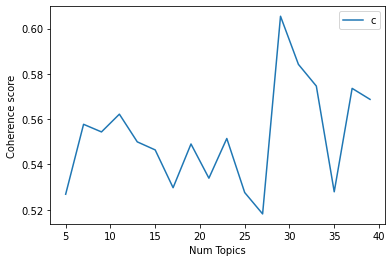

Total time taken is 483.535 seconds


In [21]:
limit=40; start=5; step=2;

st = time()
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(
    dictionary=tweets_dict, corpus=bow_corpus, texts=token_tweets,
     start=start, limit=limit, step=step)

# Show graph

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

et = time()

print ('Total time taken is {:2.3f} seconds'.format(et-st))

In [22]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.5268
Num Topics = 7  has Coherence Value of 0.5577
Num Topics = 9  has Coherence Value of 0.5544
Num Topics = 11  has Coherence Value of 0.5622
Num Topics = 13  has Coherence Value of 0.55
Num Topics = 15  has Coherence Value of 0.5464
Num Topics = 17  has Coherence Value of 0.5297
Num Topics = 19  has Coherence Value of 0.549
Num Topics = 21  has Coherence Value of 0.5339
Num Topics = 23  has Coherence Value of 0.5515
Num Topics = 25  has Coherence Value of 0.5276
Num Topics = 27  has Coherence Value of 0.5181
Num Topics = 29  has Coherence Value of 0.6055
Num Topics = 31  has Coherence Value of 0.5842
Num Topics = 33  has Coherence Value of 0.5746
Num Topics = 35  has Coherence Value of 0.5279
Num Topics = 37  has Coherence Value of 0.5736
Num Topics = 39  has Coherence Value of 0.5687


In [23]:
# Select the model and print the topics
optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))


[(0,
  '0.105*"look like" + 0.063*"thirty second" + 0.059*"david bowie" + '
  '0.055*"feel like" + 0.044*"full moon" + 0.034*"jeff bezos" + 0.032*"last '
  'town" + 0.031*"peace earth" + 0.030*"bezos count" + 0.030*"mastermind '
  'behind"'),
 (1,
  '0.065*"solar system" + 0.055*"elon musk" + 0.048*"far far" + 0.043*"cloud '
  'universe" + 0.043*"sun back" + 0.042*"far hill" + 0.042*"universe across" + '
  '0.042*"back far" + 0.041*"way back" + 0.040*"hill around"'),
 (2,
  '0.100*"scorpio moon" + 0.074*"capricorn venus" + 0.064*"sun moon" + '
  '0.064*"moon capricorn" + 0.063*"aquarius moon" + 0.063*"uptown funk" + '
  '0.060*"gucci mane" + 0.060*"wake sky" + 0.057*"bruno kodak" + 0.057*"kodak '
  'black"'),
 (3,
  '0.324*"moon initiative" + 0.319*"initiative budget" + 0.319*"statement '
  'moon" + 0.019*"budget space" + 0.013*"versace floor" + 0.000*"venus gemini" '
  '+ 0.000*"venus leo" + 0.000*"quality time" + 0.000*"cancer moon" + '
  '0.000*"word affirmation"'),
 (4,
  '0.171*"y

In [24]:
def save_plot_lda_model(lda_model):

    # Save LDA model to file
    lda_model.save(LDA_MODEL_FILE)
    print ('LDA model saved\n')
    
    # Save all generated topics to a file
    msg = ''
    for idx, topic in lda_model.print_topics(-1):
        msg += 'Topic: {} \nWords: {}\n'.format(idx, topic)    
    save_print_to_file(LDA_TOPICS_FILE, msg)
    
    # Evaluate LDA model performance

#     Compute Perplexity: a measure of how good the model is. A lower value is better.
    print('\nPerplexity: ', lda_model.log_perplexity(tfidf_corpus)) 

    # Visualize topics

    lda_data =  pyLDAvis.gensim.prepare(lda_model, tfidf_corpus, 
                                        tweets_dict, mds='mmds')
    
    viz_data = pyLDAvis.display(lda_data)

    pyLDAvis.save_html(lda_data, TOPIC_VIS_FILE)
    print ('Topic visual saved\n')
        
    return lda_model, viz_data

In [25]:
# Train LDA model and visualize generated topics

lda_model, viz_data = save_plot_lda_model(optimal_model)

pd.options.display.max_colwidth = 10000
viz_data

LDA model saved


Perplexity:  -6.0103528505452015
Topic visual saved



Reference:

* https://towardsdatascience.com/topic-modeling-of-2019-hr-tech-conference-twitter-d16cf75895b6

* https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#19findthemostrepresentativedocumentforeachtopic